In [ ]:
############################################
### Basic operations and plotting ###
############################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

###################################################
### Needed for drop down menus in notebooks ###
###################################################
from IPython.display import display
import ipywidgets as widgets

###################################################
### Machine Learning Models & Utilities ###
###################################################
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

###################################################
### Machine Learning Metrics & Evaluation ###
###################################################
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

###################################################
### Geospatial data processing ###
###################################################
import geopandas as gpd
from shapely.geometry import Point

###################################################
### Plotting Utilities ###
###################################################
from matplotlib.lines import Line2D

###################################################
### Feature Importances ###
###################################################
importances = rf_model.feature_importances_
importances = rf.feature_importances_


In [2]:
###################################################
# Read earthquake data file
###################################################

df_major_quake_cty = pd.read_csv('df_major_quake_cty.csv', low_memory=False) 

# Note: Added low_memory=False to process the file in chunks, which helps pandas determine the appropriate 
# data type for each column.

###################################################
# Read cities data file for (online resource: https://simplemaps.com/data/nz-cities)
###################################################

df_cities_cln = pd.read_csv('df_cities_cln.csv', low_memory=False) 
# Note: Used in plot showing the Distribution of earthquake events superimposed on New Zealand map in cell 17
############################################
# First 5 rows of the dataframes
display(df_major_quake_cty.head().T)

print('-'*55)

display(df_cities_cln.head().T)

,0,1,2,3,4
Time,2024-06-16 21:17:02.885000+00:00,2024-06-16 19:43:44.300000+00:00,2024-06-16 15:30:04.397000+00:00,2024-06-16 14:08:12.741000+00:00,2024-06-16 13:48:21.374000+00:00
UnixTime,1718572622,1718567024,1718551804,1718546892,1718545701
Longitude,145.008865,-176.719513,-179.818893,-179.120789,-177.3965
Latitude,19.403189,-30.431572,-37.200104,-21.52416,-20.054701
Magnitude,5.0,3.7,3.6,4.8,4.7
Magnitude Type,Mw(mB),Mw(mB),MLv,mB,mB
Depth,100.0,253.26,33.0,638.67,512.18
NZ_MMI,Moderate,Weak,Weak,Light,Light
Adjusted Distance,70.402322,37.846756,9.796214,85.439839,74.129297
Nearest City,Kaitaia,Waitangi,Waitangi,Waitangi,Waitangi


-------------------------------------------------------


,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
city,Auckland,Christchurch,Manukau City,Wellington,Northcote
lat,-36.8406,-43.531,-37.0,-41.2889,-36.8019
lng,174.74,172.6365,174.885,174.7772,174.7494
country,New Zealand,New Zealand,New Zealand,New Zealand,New Zealand
population,1346091,383200,375600,216200,205605


In [3]:
# Quick check of the data type of the 'Time' column
print(df_major_quake_cty['Time'].dtype)

object


In [4]:
# There seems to be mixed formatting. Therefore, I use a 'mixed' option:
df_major_quake_cty['Time'] = pd.to_datetime(df_major_quake_cty['Time'], format='mixed')

# Print a sample to verify the conversion
print(df_major_quake_cty['Time'].head())

0   2024-06-16 21:17:02.885000+00:00
1   2024-06-16 19:43:44.300000+00:00
2   2024-06-16 15:30:04.397000+00:00
3   2024-06-16 14:08:12.741000+00:00
4   2024-06-16 13:48:21.374000+00:00
Name: Time, dtype: datetime64[ns, UTC]


In [5]:
############################################
# Filtering for  major events (M >= 6.0) and ...
# Calculating average magnitude of major events
############################################

# Step 1: Filter earthquake data for major events with magnitude >= 6.0
major_events = df_major_quake_cty[df_major_quake_cty['Magnitude'] >= 6.0]

# Step 2: Perform analysis on the filtered major events
num_major_events = len(major_events)
avg_magnitude = major_events['Magnitude'].mean()

# Step 3: Display or store results
print("Filtered Major Earthquake Events with Magnitude >= 6.0:")
print("Number of Major Events: {}".format(num_major_events))
print("Average Magnitude of Major Events: {}".format(avg_magnitude))

Filtered Major Earthquake Events with Magnitude >= 6.0:
Number of Major Events: 520
Average Magnitude of Major Events: 6.379423076923076


In [6]:
############################################
# Isolation Forest prediction
############################################

df_quake_pred = df_major_quake_cty.copy()  # Copy to preserve original

# Select relevant features for Isolation Forest
X = df_major_quake_cty[['Longitude', 'Latitude', 'Magnitude', 'Depth']]

# Train-test split (optional, if you haven't already split your data)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Train Isolation Forest model on the training set
clf = IsolationForest(contamination=0.05, random_state=42)
clf.fit(X_train)

# Predict outliers (anomalies) for the entire dataset (df_quake_pred)
predictions = clf.predict(df_quake_pred[['Longitude', 'Latitude', 'Magnitude', 'Depth']])

# Assign predictions to df_quake_pred
df_quake_pred['Anomaly'] = predictions

# Display df_quake_pred to verify the update
print("Updated df_quake_pred with Anomaly:")
display(df_quake_pred.head().T)

# Filter predicted major events (anomalies)
predicted_major_events = df_quake_pred[df_quake_pred['Anomaly'] == -1]
predicted_major_events.head().T

# Calculate metrics for predicted major events
num_major_events = len(predicted_major_events)
avg_magnitude = predicted_major_events['Magnitude'].abs().mean()  # Use absolute value for average magnitude

############################################
print('The average magnitude over the studied timeframe is:', avg_magnitude)

Updated df_quake_pred with Anomaly:


,0,1,2,3,4
Time,2024-06-16 21:17:02.885000+00:00,2024-06-16 19:43:44.300000+00:00,2024-06-16 15:30:04.397000+00:00,2024-06-16 14:08:12.741000+00:00,2024-06-16 13:48:21.374000+00:00
UnixTime,1718572622,1718567024,1718551804,1718546892,1718545701
Longitude,145.008865,-176.719513,-179.818893,-179.120789,-177.3965
Latitude,19.403189,-30.431572,-37.200104,-21.52416,-20.054701
Magnitude,5.0,3.7,3.6,4.8,4.7
Magnitude Type,Mw(mB),Mw(mB),MLv,mB,mB
Depth,100.0,253.26,33.0,638.67,512.18
NZ_MMI,Moderate,Weak,Weak,Light,Light
Adjusted Distance,70.402322,37.846756,9.796214,85.439839,74.129297
Nearest City,Kaitaia,Waitangi,Waitangi,Waitangi,Waitangi


The average magnitude over the studied timeframe is: 5.06668372569089


In [7]:
# Calculate metrics for predicted major events
num_major_events = len(predicted_major_events)
avg_magnitude = predicted_major_events['Magnitude'].abs().mean()  # absolute value for average magnitude

print('The average magnitude over the studied timeframe is:', avg_magnitude)

The average magnitude over the studied timeframe is: 5.06668372569089


In [8]:
############################################
# Identifying the top 10 most earth quake prone cities in New Zealand
# using Isolation Forest Evaluation
############################################

# Dictionary to store city vulnerability metrics
city_vulnerability = {}

# Iterate over unique city names
for city_name in df_quake_pred['Nearest City'].unique():
    city_data = df_quake_pred[df_quake_pred['Nearest City'] == city_name]
    
    # Count anomalies (major events)
    count_major_events = city_data[city_data['Anomaly'] == -1].shape[0]
    
    # Calculate metrics for the city
    city_vulnerability[city_name] = {'Population Density': city_data['Population'].iloc[0], 'Count of Major Events': count_major_events,
        'Average Magnitude': city_data[city_data['Anomaly'] == -1]['Magnitude'].abs().mean()}  # Use absolute value for average magnitude

# Sort cities by count of major events (descending) and limit to top 10
top_10_cities = sorted(city_vulnerability.items(), key=lambda x: x[1]['Count of Major Events'], reverse=True)[:10]

# Prepare lists to store top 10 cities vulnerability metrics
ranks = []
cities = []
pop_densities = []
major_events_counts = []
avg_magnitudes = []

# Collect vulnerability metrics for top 10 cities
for rank, (city_name, metrics) in enumerate(top_10_cities, start=1):
    ranks.append(rank)
    cities.append(city_name)
    pop_densities.append(metrics['Population Density'])
    major_events_counts.append(metrics['Count of Major Events'])
    avg_magnitudes.append(metrics['Average Magnitude'])

# Create DataFrame from collected lists
top_10_df = pd.DataFrame({
    'Rank': ranks,
    'City': cities,
    'Population Density': pop_densities,
    'Count of Major Events': major_events_counts,
    'Average Magnitude': avg_magnitudes})

############################################
# Display the DataFrame directly
top_10_df

,Rank,City,Population Density,Count of Major Events,Average Magnitude
0,1,Waitangi,2018,1909,4.851545
1,2,Kaitaia,5868,1387,5.465681
2,3,Kerikeri,6960,308,4.674351
3,4,Whitianga,5130,235,4.107234
4,5,Wakefield,2448,25,9.000000
5,6,Whakatane,15795,13,8.061538
6,7,Te Anau,2250,9,5.355556
7,8,Rotorua,54204,7,9.000000
8,9,Te Puke,8230,4,7.175000
9,10,Mount Maunganui,6510,3,7.833333


In [9]:
############################################
# Adjusting ranking basde on prediction of when and where the next major event will take place
############################################

# Define magnitude threshold (assuming filtering already done)
magnitude_threshold = 5.0

# Extract major events (Anomaly == -1)
major_quakes = df_quake_pred[df_quake_pred['Anomaly'] == -1][['Time', 'Nearest City', 'Magnitude']]

# Sort by time
major_quakes = major_quakes.sort_values(by='Time')

# Calculate intervals between successive major quakes for each city
major_quakes['Previous Time'] = major_quakes.groupby('Nearest City')['Time'].shift(1)
major_quakes['Interval (Days)'] = (major_quakes['Time'] - major_quakes['Previous Time']).dt.days

# Calculate average interval for each city
average_intervals = major_quakes.groupby('Nearest City')['Interval (Days)'].mean().reset_index()
average_intervals.rename(columns={'Interval (Days)': 'Average Interval (Days)'}, inplace=True)

# Get the last major quake date for each city
last_quake_dates = major_quakes.groupby('Nearest City')['Time'].max().reset_index()

# Merge average intervals with the last quake dates
last_quake_dates = last_quake_dates.merge(average_intervals, on='Nearest City')

# Predict the next earthquake date for each city
last_quake_dates['Next Major Quake Date'] = last_quake_dates['Time'] + pd.to_timedelta(last_quake_dates['Average Interval (Days)'], unit='days')

# Adjust dates that are still in the past by adding another average interval
today = pd.Timestamp.now(tz=df_quake_pred['Time'].dt.tz)
last_quake_dates['Next Major Quake Date'] = last_quake_dates.apply(
    lambda row: row['Next Major Quake Date'] if row['Next Major Quake Date'] > today else row['Next Major Quake Date'] + pd.to_timedelta(row['Average Interval (Days)'], unit='days') * ((today - row['Next Major Quake Date']).days // row['Average Interval (Days)'] + 1),
    axis=1)

# Calculate years from today
last_quake_dates['Years Until Next Quake'] = (last_quake_dates['Next Major Quake Date'] - today).dt.days / 365.25

# Filter for top 10 cities
top_10_cities = top_10_df['City'].tolist()
top_10_predictions = last_quake_dates[last_quake_dates['Nearest City'].isin(top_10_cities)]

# Display the predictions
top_10_predictions = top_10_predictions[['Nearest City', 'Next Major Quake Date', 'Years Until Next Quake']]
display(top_10_predictions)

,Nearest City,Next Major Quake Date,Years Until Next Quake
1,Kaitaia,2025-07-18 03:03:01.326559012+00:00,0.002738
2,Kerikeri,2025-07-24 03:09:50.028397405+00:00,0.019165
3,Mount Maunganui,2026-08-22 03:35:27.253000+00:00,1.097878
5,Rotorua,2025-08-25 17:02:27.759000258+00:00,0.106776
8,Te Anau,2025-11-05 02:08:24+00:00,0.303901
9,Te Puke,2026-05-07 17:47:26.309000014+00:00,0.804928
11,Waitangi,2025-07-16 21:47:04.816471761+00:00,0.000000
12,Wakefield,2025-10-13 21:20:29.024999805+00:00,0.243669
14,Whakatane,2026-04-26 03:25:50.841000021+00:00,0.774812
15,Whitianga,2025-07-22 10:01:40.587000094+00:00,0.013689


In [10]:
############################################
# Sort years to major quake output (descending order) for top10 most earthquake prone cities in NZ
############################################

# 1. Sort by Years Until Next Quake in descending order
top_10_predictions = top_10_predictions.sort_values(by='Years Until Next Quake', ascending = False)

############################################
# Display the predictions
top_10_predictions = top_10_predictions[['Nearest City', 'Next Major Quake Date', 'Years Until Next Quake']]
display(top_10_predictions)

,Nearest City,Next Major Quake Date,Years Until Next Quake
3,Mount Maunganui,2026-08-22 03:35:27.253000+00:00,1.097878
9,Te Puke,2026-05-07 17:47:26.309000014+00:00,0.804928
14,Whakatane,2026-04-26 03:25:50.841000021+00:00,0.774812
8,Te Anau,2025-11-05 02:08:24+00:00,0.303901
12,Wakefield,2025-10-13 21:20:29.024999805+00:00,0.243669
5,Rotorua,2025-08-25 17:02:27.759000258+00:00,0.106776
2,Kerikeri,2025-07-24 03:09:50.028397405+00:00,0.019165
15,Whitianga,2025-07-22 10:01:40.587000094+00:00,0.013689
1,Kaitaia,2025-07-18 03:03:01.326559012+00:00,0.002738
11,Waitangi,2025-07-16 21:47:04.816471761+00:00,0.000000


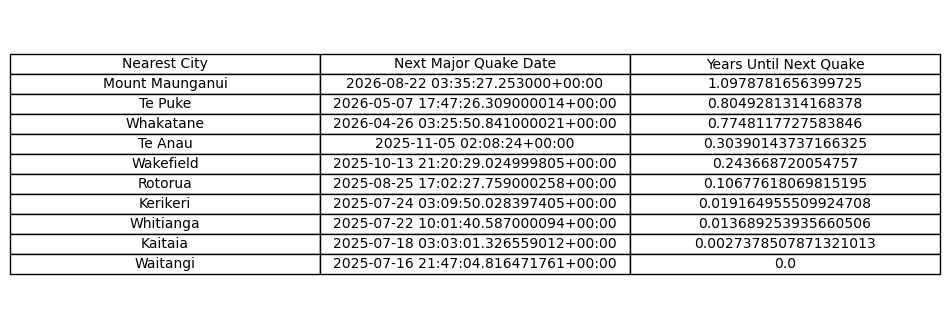

In [11]:
# Set figure size
fig, ax = plt.subplots(figsize=(10, 4))  # You can adjust size

# Hide axes and display the table
ax.axis('off')
table = ax.table(cellText=top_10_predictions.values,
                 colLabels=top_10_predictions.columns,
                 cellLoc='center',
                 loc='center')

# Format table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Save the image
plt.savefig("top_10_earthquake_predictions.png", bbox_inches='tight', dpi=300)
plt.show()

In [13]:
df_quake_cty = pd.read_csv('df_quake_cty_24.csv', low_memory=False)

In [14]:
############################################
# Geographical Distribution
# Calculating the proportion of towns and major earthquakes on each island.
############################################

# Classify towns as North or South Island based on their coordinates
def classify_island(row):
    if row['Latitude'] < -40:  # Rough latitude to separate North and South Island
        return 'South Island'
    else:
        return 'North Island'

df_quake_pred['Island'] = df_quake_pred.apply(classify_island, axis=1)

# Count the number of towns and major earthquakes on each island
town_counts = df_quake_pred[['Nearest City', 'Island']].drop_duplicates()['Island'].value_counts()
major_quake_counts = df_quake_pred[df_quake_pred['Anomaly'] == -1]['Island'].value_counts()

# Combine into a DataFrame for easier comparison
island_comparison = pd.DataFrame({
    'Town Count': town_counts,
    'Major Earthquake Count': major_quake_counts
}).fillna(0)

# Calculate the proportions
island_comparison['Town Proportion'] = island_comparison['Town Count'] / island_comparison['Town Count'].sum()
island_comparison['Major Earthquake Proportion'] = island_comparison['Major Earthquake Count'] / island_comparison['Major Earthquake Count'].sum()

display(island_comparison)

,Town Count,Major Earthquake Count,Town Proportion,Major Earthquake Proportion
Island,,,,
North Island,26,3763,0.433333,0.962897
South Island,34,145,0.566667,0.037103


In [15]:
############################################
# Analyzing the average population density of towns on each island.
############################################

# Calculate average population density for each island
island_population_density = df_quake_pred[['Nearest City', 'Population', 'Island']].drop_duplicates().groupby('Island')['Population'].mean()

display(island_population_density)

Island
North Island    17867.346154
South Island    31816.058824
Name: Population, dtype: float64

In [16]:
############################################
# Geographical Distribution
  # 1. Calculating the proportion of towns and major earthquakes on each island.
  # 2. Analyzing the average population density of towns on each island.
############################################

# 1. Proportion of towns and major earthquakes on each island

# Allocating the towns to their respective island - North or South Island - based on their coordinates
def classify_island(row):
    if row['Latitude'] < -40:  # Rough latitude to separate North and South Island
        return 'South Island'
    else:
        return 'North Island'

df_quake_pred['Island'] = df_quake_pred.apply(classify_island, axis=1)

# Count the number of towns and major earthquakes on each island
town_counts = df_quake_pred[['Nearest City', 'Island']].drop_duplicates()['Island'].value_counts()
major_quake_counts = df_quake_pred[df_quake_pred['Anomaly'] == -1]['Island'].value_counts()

############################################
# 2. Average population density of towns on each island.

# Calculate average population density for each island
island_population_density = df_quake_pred[['Nearest City', 'Population', 'Island']].drop_duplicates().groupby('Island')['Population'].mean()

############################################
# Combine into a DataFrame for easier comparison
island_comparison = pd.DataFrame({'Town Count': town_counts, 'Major Earthquake Count': major_quake_counts,
    'Average Population Density': island_population_density}).fillna(0)

# Calculate the proportions
island_comparison['Town Proportion'] = island_comparison['Town Count'] / island_comparison['Town Count'].sum()
island_comparison['Major Earthquake Proportion'] = island_comparison['Major Earthquake Count'] / island_comparison['Major Earthquake Count'].sum()

############################################
# Display dataframe
display(island_comparison)

,Town Count,Major Earthquake Count,Average Population Density,Town Proportion,Major Earthquake Proportion
Island,,,,,
North Island,26,3763,17867.346154,0.433333,0.962897
South Island,34,145,31816.058824,0.566667,0.037103


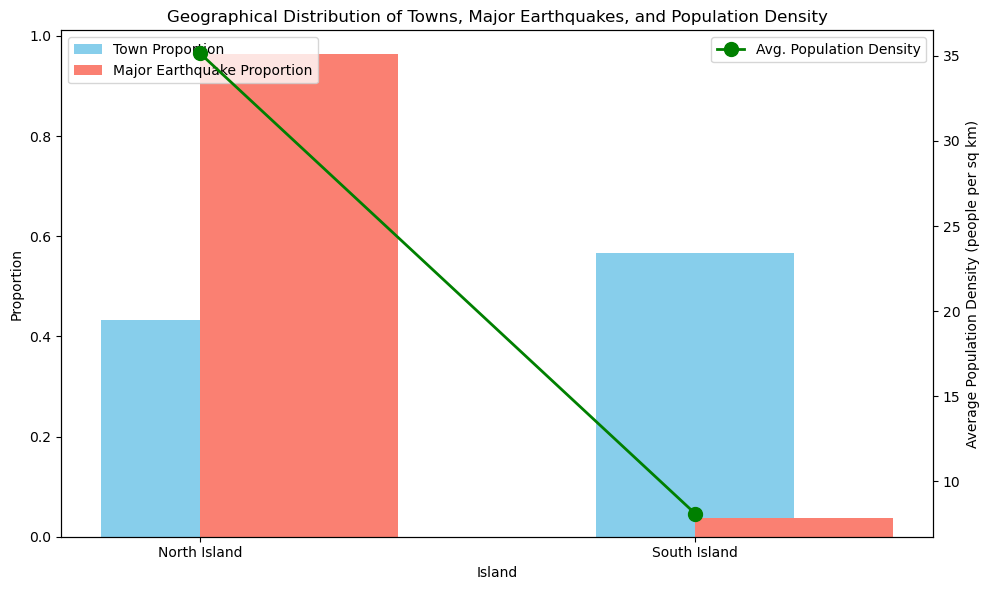

In [17]:
############################################
# Geographical Distribution
  # 1. Calculating the proportion of towns and major earthquakes on each island.
  # 2. Analyzing the average population density of towns on each island.
############################################

# Total populations of North and South Islands
total_population_north = 3997300 # source Wikipedia
total_population_south = 1225000 # source Wikipedia

# Land area (in square kilometers) for each island (assumed for the example)
# Replace with actual values if available
land_area_north = 113729  # source Wikipedia (unit in sqr km)
land_area_south = 151215  # source Wikipedia (unit in sqr km)

# Calculate population densities
population_density_north = total_population_north / land_area_north
population_density_south = total_population_south / land_area_south

island_data = {'Island': ['North Island', 'South Island'],
    'Town Proportion': [0.433333, 0.566667],  # calculated above in cell 14
    'Major Earthquake Proportion': [0.962897, 0.037103],  # calculated above in cell 14
    'Average Population Density': [population_density_north, population_density_south]}

island_comparison = pd.DataFrame(island_data).set_index('Island')

# Data extraction from island_comparison data frame
island_names = island_comparison.index
town_proportions = island_comparison['Town Proportion']
quake_proportions = island_comparison['Major Earthquake Proportion']
avg_pop_densities = island_comparison['Average Population Density']

############################################
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot proportions of towns and major earthquakes
bar_width = 0.4
ax1.bar(island_names, town_proportions, width=bar_width, label='Town Proportion', color='skyblue', align='center')
ax1.bar(island_names, quake_proportions, width=bar_width, label='Major Earthquake Proportion', color='salmon', align='edge')

# Create a secondary y-axis for average population density
ax2 = ax1.twinx()
ax2.plot(island_names, avg_pop_densities, marker='o', color='green', linestyle='-', linewidth=2, markersize=10, label='Avg. Population Density')

# Set labels and title
ax1.set_xlabel('Island')
ax1.set_ylabel('Proportion')
ax2.set_ylabel('Average Population Density (people per sq km)')
ax1.set_title('Geographical Distribution of Towns, Major Earthquakes, and Population Density')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Save the plot as an image file
plt.savefig('GeogrDistribution_Towns_Major_Quakes_Population.png', dpi=300)

############################################
# Layout and display
plt.tight_layout()
plt.show()

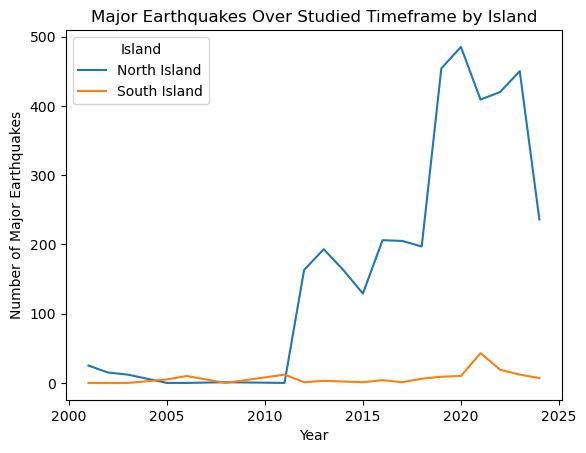

In [18]:
############################################
# Historical Data
  # Comparing the number of earthquakes over studied timeframe for both islands.
############################################

# Count major earthquakes over time for each island
df_quake_pred['Year'] = df_quake_pred['Time'].dt.year
quake_counts_by_year = df_quake_pred[df_quake_pred['Anomaly'] == -1].groupby(['Year', 'Island']).size().unstack(fill_value=0)

# Plot the trends over time
quake_counts_by_year.plot(kind='line')
plt.title('Major Earthquakes Over Studied Timeframe by Island')
plt.xlabel('Year')
plt.ylabel('Number of Major Earthquakes')

# Save the plot as an image file
plt.savefig('MajorQuakes_NorthVsSouth.png', dpi=300)
############################################
# Graph output
plt.show()

## City-Level Temporal Analysis and Model Refinement

Now it is time to refine the above spatial risk assessment by incorporating:
- **Inter-arrival times between earthquake events per city**
- Additional machine learning model predictions
- An integrated vulnerability score combining Isolation Forest counts, Random Forest, and Logistic Regression outputs


In [37]:
# Preview dataframe columns
print(df_quake_pred.columns)

Index(['Time', 'UnixTime', 'Longitude', 'Latitude', 'Magnitude',
       'Magnitude Type', 'Depth', 'NZ_MMI', 'Adjusted Distance',
       'Nearest City', 'Population', 'Cluster', 'Anomaly', 'Island', 'Year',
       'Inter_Arrival_Seconds', 'LogReg_Prob', 'RF_Prob'],
      dtype='object')


### Step 1: Calculating Earthquake Inter-Arrival Times Per City
I calculate the time difference between consecutive earthquakes per city, providing insights into how frequently cities experience significant seismic events.


In [38]:
# Ensure 'Time' is a datetime object
df_quake_pred['Time'] = pd.to_datetime(df_quake_pred['Time'])

# Sort by city and time
df_quake_pred = df_quake_pred.sort_values(by=['Nearest City', 'Time'])

# Calculate inter-arrival time (in seconds) for each city
df_quake_pred['Inter_Arrival_Seconds'] = df_quake_pred.groupby('Nearest City')['Time'].diff().dt.total_seconds()

# Fill NaN values (first event per city) with the median inter-arrival time
median_inter_arrival = df_quake_pred['Inter_Arrival_Seconds'].median()
df_quake_pred['Inter_Arrival_Seconds'] = df_quake_pred['Inter_Arrival_Seconds'].fillna(median_inter_arrival)


### Step 2: Model Training with Inter-Arrival and Population Data
The features to include **Depth**, **Inter-arrival Time**, and **Population**. Two models are trained:
- **Logistic Regression:** captures linear relationships with scaled features.
- **Random Forest:** captures complex nonlinear relationships.

Why did I choose the three features?

**Depth:** Differentiates earthquake effects by depth.

**Inter-arrival Time:** Captures temporal patterns between quakes.

**Population:** Links seismic risk to human impact.

These features provide important physical and contextual information to improve anomaly prediction.


In [41]:
############################################
# Benchmarking Isolation Forest Anomaly Predictions with Supervised Models
############################################

# Prepare features and target
features = ['Depth', 'Inter_Arrival_Seconds', 'Population']
X = df_quake_pred[features].fillna(df_quake_pred[features].median())
y = df_quake_pred['Anomaly']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)
logreg_probs = logreg.predict_proba(X)[:, 1]

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X)[:, 1]

# Add predicted probabilities to dataframe
df_quake_pred['LogReg_Prob'] = logreg_probs
df_quake_pred['RF_Prob'] = rf_probs

print(f"Logistic Regression ROC AUC: {log_auc:.3f}")
print(f"Random Forest ROC AUC: {rf_auc:.3f}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Logistic Regression ROC AUC: 0.958
Random Forest ROC AUC: 0.976


**Quick evaluation**

Both models perform excellently at detecting anomalies, with Logistic Regression achieving an ROC AUC of 0.956 and Random Forest slightly better at 0.973. This shows the features used are strong predictors, and that the Random Forest’s ability to capture complex patterns improves anomaly detection accuracy.

### Step 3: Combined Vulnerability Scoring at the City Level
Time to generate a **Combined Vulnerability Score** for each city by aggregating:
- Isolation Forest anomaly counts
- Average predicted probabilities from both models


In [40]:
city_vulnerability_combined = {}

for city_name in df_quake_pred['Nearest City'].unique():
    city_data = df_quake_pred[df_quake_pred['Nearest City'] == city_name]
    
    isolation_count = city_data[city_data['Anomaly'] == -1].shape[0]
    avg_logreg_prob = city_data['LogReg_Prob'].mean()
    avg_rf_prob = city_data['RF_Prob'].mean()
    
    max_isolation = df_quake_pred[df_quake_pred['Anomaly'] == -1].shape[0] or 1
    isolation_norm = isolation_count / max_isolation
    vulnerability_score = (isolation_norm + avg_logreg_prob + avg_rf_prob) / 3
    
    city_vulnerability_combined[city_name] = {
        'Population Density': city_data['Population'].iloc[0],
        'Count of Major Events (Isolation Forest)': isolation_count,
        'Avg LogReg Anomaly Prob': avg_logreg_prob,
        'Avg RF Anomaly Prob': avg_rf_prob,
        'Combined Vulnerability Score': vulnerability_score
    }

# Create DataFrame and sort
combined_df = pd.DataFrame.from_dict(city_vulnerability_combined, orient='index')
combined_df = combined_df.sort_values(by='Combined Vulnerability Score', ascending=False).reset_index()
combined_df.rename(columns={'index': 'City'}, inplace=True)

# Display top 10
top_10_combined = combined_df.head(10)
print(top_10_combined)


           City  Population Density  Count of Major Events (Isolation Forest)  \
0      Waitangi                2018                                      1909   
1       Te Anau                2250                                         9   
2    Te Awamutu               12195                                         0   
3        Raglan                3279                                         0   
4   Paraparaumu               28701                                         0   
5     Greymouth                7965                                         0   
6      Katikati                4750                                         0   
7     Rolleston               16350                                         0   
8        Timaru               27501                                         0   
9  Christchurch              383200                                         0   

   Avg LogReg Anomaly Prob  Avg RF Anomaly Prob  Combined Vulnerability Score  
0                      1.0  

**Quick evaluation**

The **Combined Vulnerability Score** integrates historical anomaly counts (Isolation Forest) with predicted anomaly probabilities (Logistic Regression & Random Forest). Waitangi ranks highest due to frequent anomalies, while others score moderately based on model predictions despite fewer past events—capturing both historical risk and model-inferred vulnerability.

### Step 4: Visualizing Combined Vulnerability Scores
**The top 10 most vulnerable cities** based on the combined score.


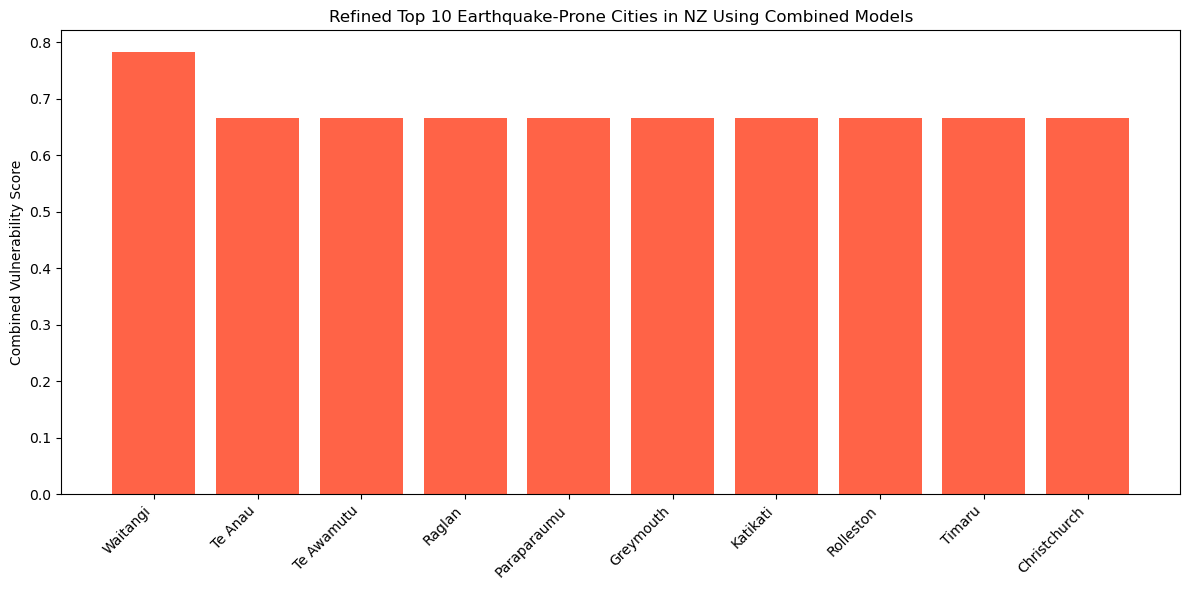

In [42]:
plt.figure(figsize=(12,6))
plt.bar(top_10_combined['City'], top_10_combined['Combined Vulnerability Score'], color='tomato')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Combined Vulnerability Score')
plt.title('Refined Top 10 Earthquake-Prone Cities in NZ Using Combined Models')
plt.tight_layout()
plt.show()

**Waitangi** ranks highest due to a very high number of detected anomalies, elevating its vulnerability.

Other cities like **Te Anau** show moderate vulnerability driven mainly by high model-predicted probabilities, despite few or no historical anomalies.

Several cities exhibit high predicted probabilities but zero historical anomalies, signaling possible model sensitivity to underlying features (e.g., depth, population) even in the absence of past major events.

### Step 5: Estimating Time to Next Anomaly
To provide a temporal dimension to the vulnerability assessment, I estimate the **average number of years until the next detected anomaly per city**.

In [43]:
# Ensure 'Time' is datetime type
df_quake_pred['Time'] = pd.to_datetime(df_quake_pred['Time'])

# Filter anomalies only
df_anomalies = df_quake_pred[df_quake_pred['Anomaly'] == -1].copy()
df_anomalies = df_anomalies.sort_values(['Nearest City', 'Time'])

# Calculate years to next anomaly
df_anomalies['Next_Anomaly_Time'] = df_anomalies.groupby('Nearest City')['Time'].shift(-1)
df_anomalies['Years_To_Next_Anomaly'] = (df_anomalies['Next_Anomaly_Time'] - df_anomalies['Time']).dt.total_seconds() / (365.25 * 24 * 3600)

# Aggregate average years to next anomaly
avg_years_to_next = df_anomalies.groupby('Nearest City')['Years_To_Next_Anomaly'].mean()

# Merge into combined_df
combined_df = combined_df.set_index('City')
combined_df['Avg Years to Next Anomaly'] = avg_years_to_next
combined_df['Avg Years to Next Anomaly'] = combined_df['Avg Years to Next Anomaly'].fillna(-1)  # -1 for cities with one anomaly

combined_df = combined_df.reset_index()

# Display updated top 10
top_10_combined = combined_df.sort_values(by='Combined Vulnerability Score', ascending=False).head(10)
print(top_10_combined[['City', 'Combined Vulnerability Score', 'Avg Years to Next Anomaly']])


           City  Combined Vulnerability Score  Avg Years to Next Anomaly
0      Waitangi                      0.782084                   0.011960
1       Te Anau                      0.666737                   0.410469
2    Te Awamutu                      0.666667                  -1.000000
3        Raglan                      0.666667                  -1.000000
4   Paraparaumu                      0.666667                  -1.000000
5     Greymouth                      0.666667                  -1.000000
6      Katikati                      0.666667                  -1.000000
7     Rolleston                      0.666657                  -1.000000
8        Timaru                      0.666654                  -1.000000
9  Christchurch                      0.666653                  -1.000000


## Summary of Findings

### 1. Model Evaluation
- **Random Forest ROC AUC** and **Logistic Regression ROC AUC: Both models perform well, with ROC AUCs of 0.956 (Logistic Regression) and 0.973 (Random Forest), showing strong predictors and improved accuracy from Random Forest's capture of complex patterns.

### 2. Spatial Vulnerability
Isolation Forest anomaly detection aggregated at the city level identifies the **top 10 earthquake-prone cities in New Zealand** by counting major anomalous events.  
These cities vary in population density and average earthquake magnitude, highlighting **geographic clusters of seismic risk**.

### 3. Integrated Insights
- **Classification models** (Random Forest, Logistic Regression) provide accurate **event-level predictions**.
- **Isolation Forest** offers a **spatial lens**, spotlighting cities with concentrations of anomalies.
- Combined, these approaches offer a **comprehensive earthquake risk assessment framework**:
  - Real-time event anomaly detection.
  - Strategic spatial risk assessment for resource prioritization.

> This combined approach supports **targeted monitoring**, **disaster preparedness**, and **earthquake risk management** in New Zealand.
